# Demand Forecasting with Prophet

## Business Case: Predictive Fleet Positioning

**Key Question:** Can we accurately forecast hourly demand to proactively position vehicles before demand spikes?

## Objectives
- Build a time series forecasting model using Facebook Prophet
- Capture daily and weekly seasonality patterns in taxi demand
- Account for US holiday effects on demand
- Generate 7-day hourly forecasts for fleet planning

## Business Impact
Accurate demand forecasting enables:
- Proactive vehicle positioning before demand surges
- Reduced customer wait times during peak hours
- Optimized driver scheduling and shift planning
- Data-driven capacity planning for special events

## Setup & Data Loading

In [1]:
import os

import plotly.graph_objects as go
import polars as pl
from prophet import Prophet

/usr/local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Load Hourly Data (Aggregated by Borough)
uri = f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@{os.getenv('POSTGRES_HOST')}:5432/{os.getenv('POSTGRES_DB')}"

query = """
SELECT 
    date_trunc('hour', pickup_datetime) as ds,
    pickup_borough,
    count(*) as y
FROM dbt_dev.fct_trips
WHERE pickup_borough IS NOT NULL
GROUP BY 1, 2
ORDER BY 1
"""
print("Loading data...")
df_pl = pl.read_database_uri(query, uri, engine="connectorx")

Loading data...


In [3]:
# 2. Filter for one Borough (e.g., Manhattan)
borough = "Manhattan"
df_manhattan = df_pl.filter(pl.col("pickup_borough") == borough).select(["ds", "y"]).to_pandas()

# Prophet requires columns named 'ds' (datetime) and 'y' (value)
# Ensure ds is tz-naive for Prophet (remove timezone info)
df_manhattan['ds'] = df_manhattan['ds'].dt.tz_localize(None)

print(f"Training Prophet model for {borough}...")

Training Prophet model for Manhattan...


In [4]:
# 3. Define Model
# We add US holidays automatically
m = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)
m.add_country_holidays(country_name='US')

In [5]:
# 4. Train
m.fit(df_manhattan)

08:58:44 - cmdstanpy - INFO - Chain [1] start processing
08:58:44 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
# 5. Forecast Future (Next 7 Days, Hourly)
future = m.make_future_dataframe(periods=24*7, freq='h')
forecast = m.predict(future)

Visualizing...


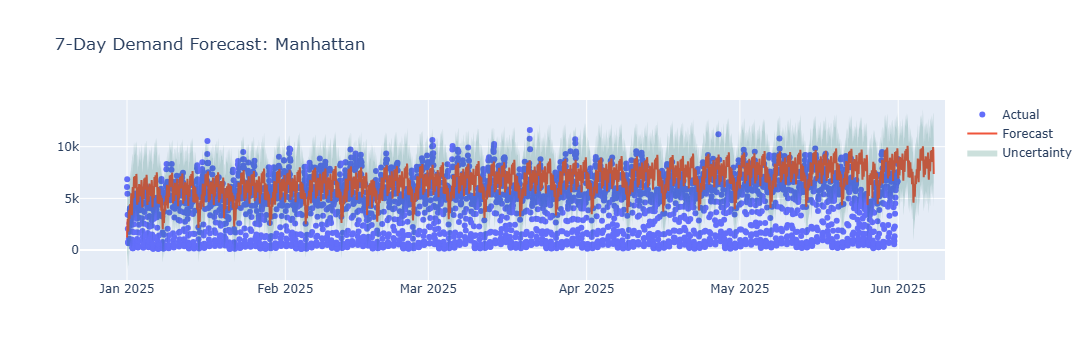

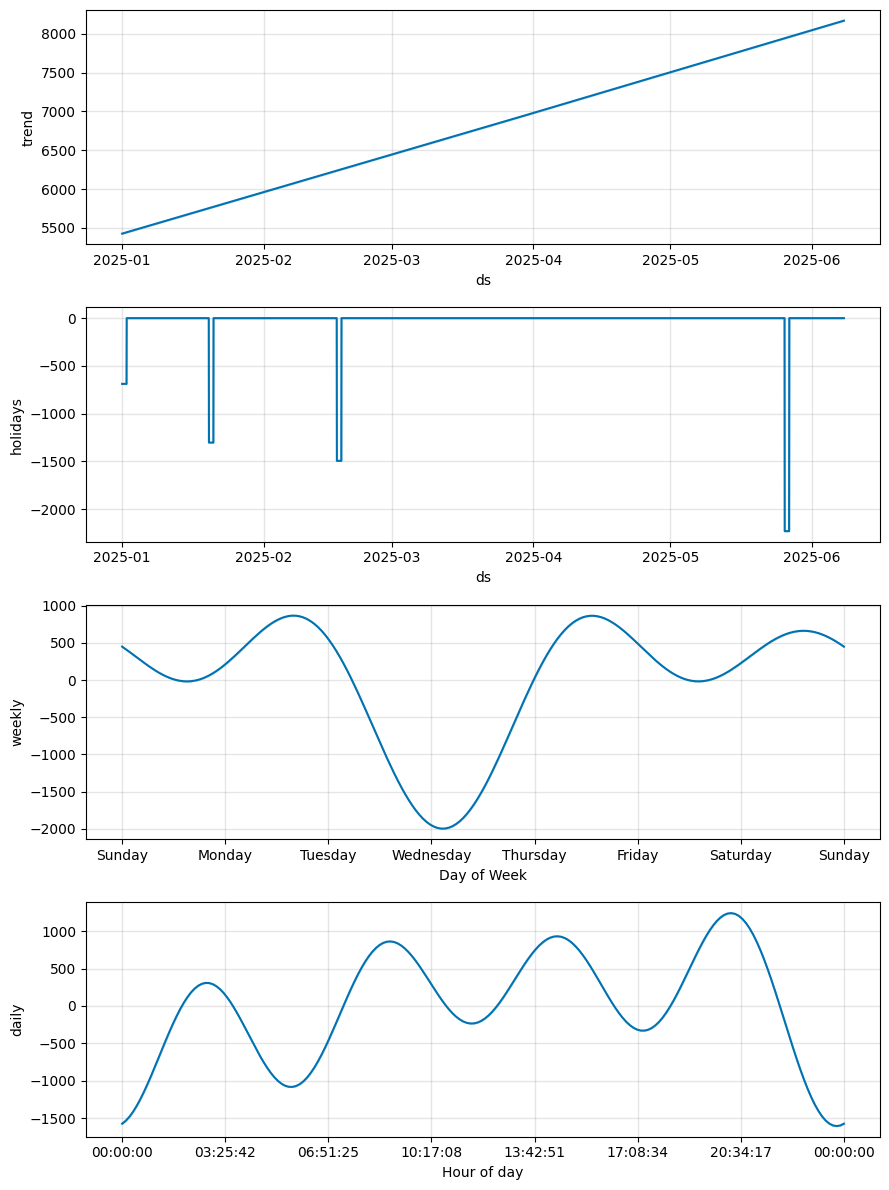

In [7]:
# 6. Visualize
print("Visualizing...")
# Plot Actuals vs Forecast
fig = go.Figure()

# Actuals
fig.add_trace(go.Scatter(x=df_manhattan['ds'], y=df_manhattan['y'], mode='markers', name='Actual'))

# Forecast
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast'))

# Confidence Interval
fig.add_trace(go.Scatter(
    x=forecast['ds'].tolist() + forecast['ds'].tolist()[::-1],
    y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Uncertainty'
))

fig.update_layout(title=f"7-Day Demand Forecast: {borough}")
fig.show()

# 7. Components (Trend vs Daily vs Weekly)
fig2 = m.plot_components(forecast)
fig2.show()

## Key findings & recommendations

### Key Findings
*   **Strong Daily Seasonality**: Manhattan taxi demand exhibits clear daily patterns with peaks during morning (8-9 AM) and evening (6-7 PM) rush hours, and troughs in early morning hours (3-5 AM).
*   **Weekly Patterns**: Weekend demand differs significantly from weekdays, with later morning peaks and sustained evening activity.
*   **Holiday Effects**: US holidays show measurable impact on demand patterns, with reduced morning rush but elevated evening/night activity.

### Business Recommendations
1.  **Dynamic Fleet Allocation**: Use hourly forecasts to pre-position vehicles 30-60 minutes before predicted demand spikes, reducing customer wait times.
2.  **Shift Optimization**: Align driver shift schedules with forecasted demand curves—stagger start times to match the morning ramp-up pattern.
3.  **Holiday Planning**: Implement special scheduling protocols for holidays, adjusting for the shifted demand patterns identified by the model.